#We build and train a multimodal network architechture on the extracted features

#Loading the data and features

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
df_train = pd.read_csv("/content/drive/MyDrive/meme_classification_data/train.csv")
df_sentiment_train = pd.read_csv("/content/drive/MyDrive/meme_classification_data/MMN_Features/train_Sentiment.csv")
df_humor_train = pd.read_csv("/content/drive/MyDrive/meme_classification_data/MMN_Features/train_Humor.csv")
df_irony_train = pd.read_csv("/content/drive/MyDrive/meme_classification_data/MMN_Features/train_Irony.csv")
df_biden_train = pd.read_csv("/content/drive/MyDrive/meme_classification_data/MMN_Features/train_Biden.csv")
df_sarcasm_train = pd.read_csv('/content/drive/MyDrive/meme_classification_data/MMN_Features/train_Sarcasm.csv')
df_humor_train = df_humor_train.loc[:, (df_humor_train != 0).any(axis=0)]
#df_extra_train.drop(columns = ['ID', 'image id', 'text', 'label_num', 'label'],inplace=True)
df_train.shape, df_sent_train.shape, df_humor_train.shape, df_irony_train.shape, df_biden_train.shape,df_sarcasm_train.shape


((1991, 5), (1991, 768), (1991, 243), (1991, 768), (1991, 768), (1991, 1))

In [27]:
from keras.utils.np_utils import to_categorical   
y = to_categorical(df_train['label_num'], num_classes=3)
X_biden = df_biden_train.values
X_humor = df_humor_train.values
X_irony = df_irony_train.values
X_sarcasm = df_sarcasm_train.values
X_sentiment = df_sentiment_train.values
X_biden.shape, X_humor.shape, X_irony.shape, X_sarcasm.shape, x_sentiment.shape, y.shape

((1991, 768), (1991, 243), (1991, 768), (1991, 1), (1991, 768), (1991, 3))

In [41]:
X_biden_train, X_biden_test, \
X_humor_train, X_humor_test,\
X_irony_train, X_irony_test,\
X_sarcasm_train, X_sarcasm_test,\
X_sentiment_train, X_sentiment_test,\
y_train, y_test = \
train_test_split(X_biden,X_humor,X_irony,X_sarcasm,X_sentiment, y, test_size=.20, random_state=103, stratify = df_train["label_num"].tolist())
X_biden_train.shape, X_humor_train.shape, X_sarcasm_train.shape,X_sentiment_train.shape, y_train.shape

((1592, 768), (1592, 243), (1592, 1), (1592, 768), (1592, 3))

# Multimodal-Network and Training

In [87]:
import itertools
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  Normalizer , scale
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error 
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Embedding, Input, dot, concatenate, merge
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Reshape
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping, ModelCheckpoint

In [99]:
# X_biden.shape, X_humor.shape, X_irony.shape, X_sarcasm.shape, x_sentiment.shape, y.shape
# ((1991, 768), (1991, 243), (1991, 768), (1991, 1), (1991, 768), (1991, 3))
input1=keras.Input(shape=(768,),name='biden')
input2=keras.Input(shape=(243,),name='humor')
input3=keras.Input(shape=(768,),name='irony')
input4=keras.Input(shape=(768,),name='sentiment')
input5=keras.Input(shape=(1,),name='sarcasm')

input1dr = keras.layers.Dropout(0.2)(input1)
input2dr = keras.layers.Dropout(0.2)(input2)
input2dr = input2
input3dr = keras.layers.Dropout(0.2)(input3)
input4dr = keras.layers.Dropout(0.3)(input4)

input1dn=layers.Dense(6,activation='sigmoid',name="Biden-Dense")(input1dr)
input2dn=layers.Dense(6,activation='sigmoid',name="Humor-Dense")(input2dr)
input3dn=layers.Dense(6,activation='sigmoid',name="Irony-Dense")(input3dr)
input4dn=layers.Dense(5,activation='sigmoid',name="Sentiment-Dense")(input4dr)


sentiment_humor = layers.concatenate([input4dn, input2dn], axis = 1)
sentiment_political = layers.concatenate([input4dn, input1dn],axis = 1)
sentiment_irony = layers.concatenate([input4dn, input3dn], axis=1)
humor_irony = layers.concatenate([input2dn, input3dn],axis=1)
political_irony = layers.concatenate([input1dn, input3dn],axis=1)


sentiment_humor_final=layers.Dense(2,activation='sigmoid', name='sentiment_humor_final')(sentiment_humor)
sentiment_political_final=layers.Dense(2,activation='sigmoid', name='sentiment_political_final')(sentiment_political)
sentiment_irony_final=layers.Dense(2,activation='sigmoid', name='sentiment_irony_final')(sentiment_irony)
humor_irony_final=layers.Dense(2,activation='sigmoid', name='humor_irony_final')(humor_irony)
political_irony_final=layers.Dense(2,activation='sigmoid', name='political_irony_final')(political_irony)



final_layer = layers.concatenate([sentiment_humor_final, sentiment_political_final,sentiment_irony_final,humor_irony_final,political_irony_final,input5], axis=1)

final_layerdr = keras.layers.Dropout(0.05, name='final_layer')(final_layer)

top_layer = keras.layers.Dense(5,activation = 'sigmoid' ,name='top_layer')(final_layer)

output=layers.Dense(3, activation='softmax', name="output")(top_layer)



In [89]:
model=keras.Model(inputs=[input1, input2, input3, input4,input5],outputs=[output])
model.compile(optimizer=RMSprop(1e-3),  loss=keras.losses.CategoricalCrossentropy(from_logits=False),  metrics=['accuracy'] ) # Last layer is softmax, hence we set from_logics = False
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentiment (InputLayer)          [(None, 768)]        0                                            
__________________________________________________________________________________________________
biden (InputLayer)              [(None, 768)]        0                                            
__________________________________________________________________________________________________
irony (InputLayer)              [(None, 768)]        0                                            
__________________________________________________________________________________________________
dropout_29 (Dropout)            (None, 768)          0           sentiment[0][0]                  
____________________________________________________________________________________________

In [70]:
model.fit(
    { "biden": X_biden_train, 
      "humor": X_humor_train ,
      "irony": X_irony_train ,
      "sentiment": X_sentiment_train ,
      "sarcasm": X_sarcasm,
     },
    {"output": y_train},
    epochs=40,
    batch_size=64,
    validation_split=0.125,
    verbose=1
)

Epoch 1/40
22/22 [==============================] - 2s 17ms/step - loss: 0.9555 - accuracy: 0.5639 - val_loss: 1.1256 - val_accuracy: 0.3518
Epoch 2/40
22/22 [==============================] - 0s 7ms/step - loss: 0.9280 - accuracy: 0.6049 - val_loss: 1.1238 - val_accuracy: 0.3518
Epoch 3/40
22/22 [==============================] - 0s 7ms/step - loss: 0.9292 - accuracy: 0.6018 - val_loss: 1.1326 - val_accuracy: 0.3417
Epoch 4/40
22/22 [==============================] - 0s 7ms/step - loss: 0.9310 - accuracy: 0.5966 - val_loss: 1.1266 - val_accuracy: 0.3668
Epoch 5/40
22/22 [==============================] - 0s 7ms/step - loss: 0.9320 - accuracy: 0.5797 - val_loss: 1.1476 - val_accuracy: 0.3216
Epoch 6/40
22/22 [==============================] - 0s 7ms/step - loss: 0.9212 - accuracy: 0.6079 - val_loss: 1.1276 - val_accuracy: 0.3518
Epoch 7/40
22/22 [==============================] - 0s 7ms/step - loss: 0.9226 - accuracy: 0.6121 - val_loss: 1.1391 - val_accuracy: 0.3467
Epoch 8/40
22/22 [=

#Results and Saving model

In [71]:
test_score= model.evaluate([X_biden_test,X_humor_test,X_irony_test,X_sentiment_test,X_sarcasm_test], y_test,verbose=2)

13/13 - 0s - loss: 1.1791 - accuracy: 0.4211


In [84]:
y_pred = model.predict([X_biden_test,X_humor_test,X_irony_test,X_sentiment_test,X_sarcasm_test])
y_pred = y_pred.argmax(axis = 1)
pred_cnt = ["Class"+str(i) +": " +str(len(y_pred[y_pred == i]))  for i in range(3) ]
print(pred_cnt)
print(classification_report(y_test.argmax(axis = 1), y_pred))

['Class0: 117', 'Class1: 167', 'Class2: 115']
              precision    recall  f1-score   support

           0       0.42      0.40      0.41       121
           1       0.41      0.50      0.45       138
           2       0.43      0.36      0.39       140

    accuracy                           0.42       399
   macro avg       0.42      0.42      0.42       399
weighted avg       0.42      0.42      0.42       399



/content/drive/MyDrive/meme_classification_data/MMN_Features


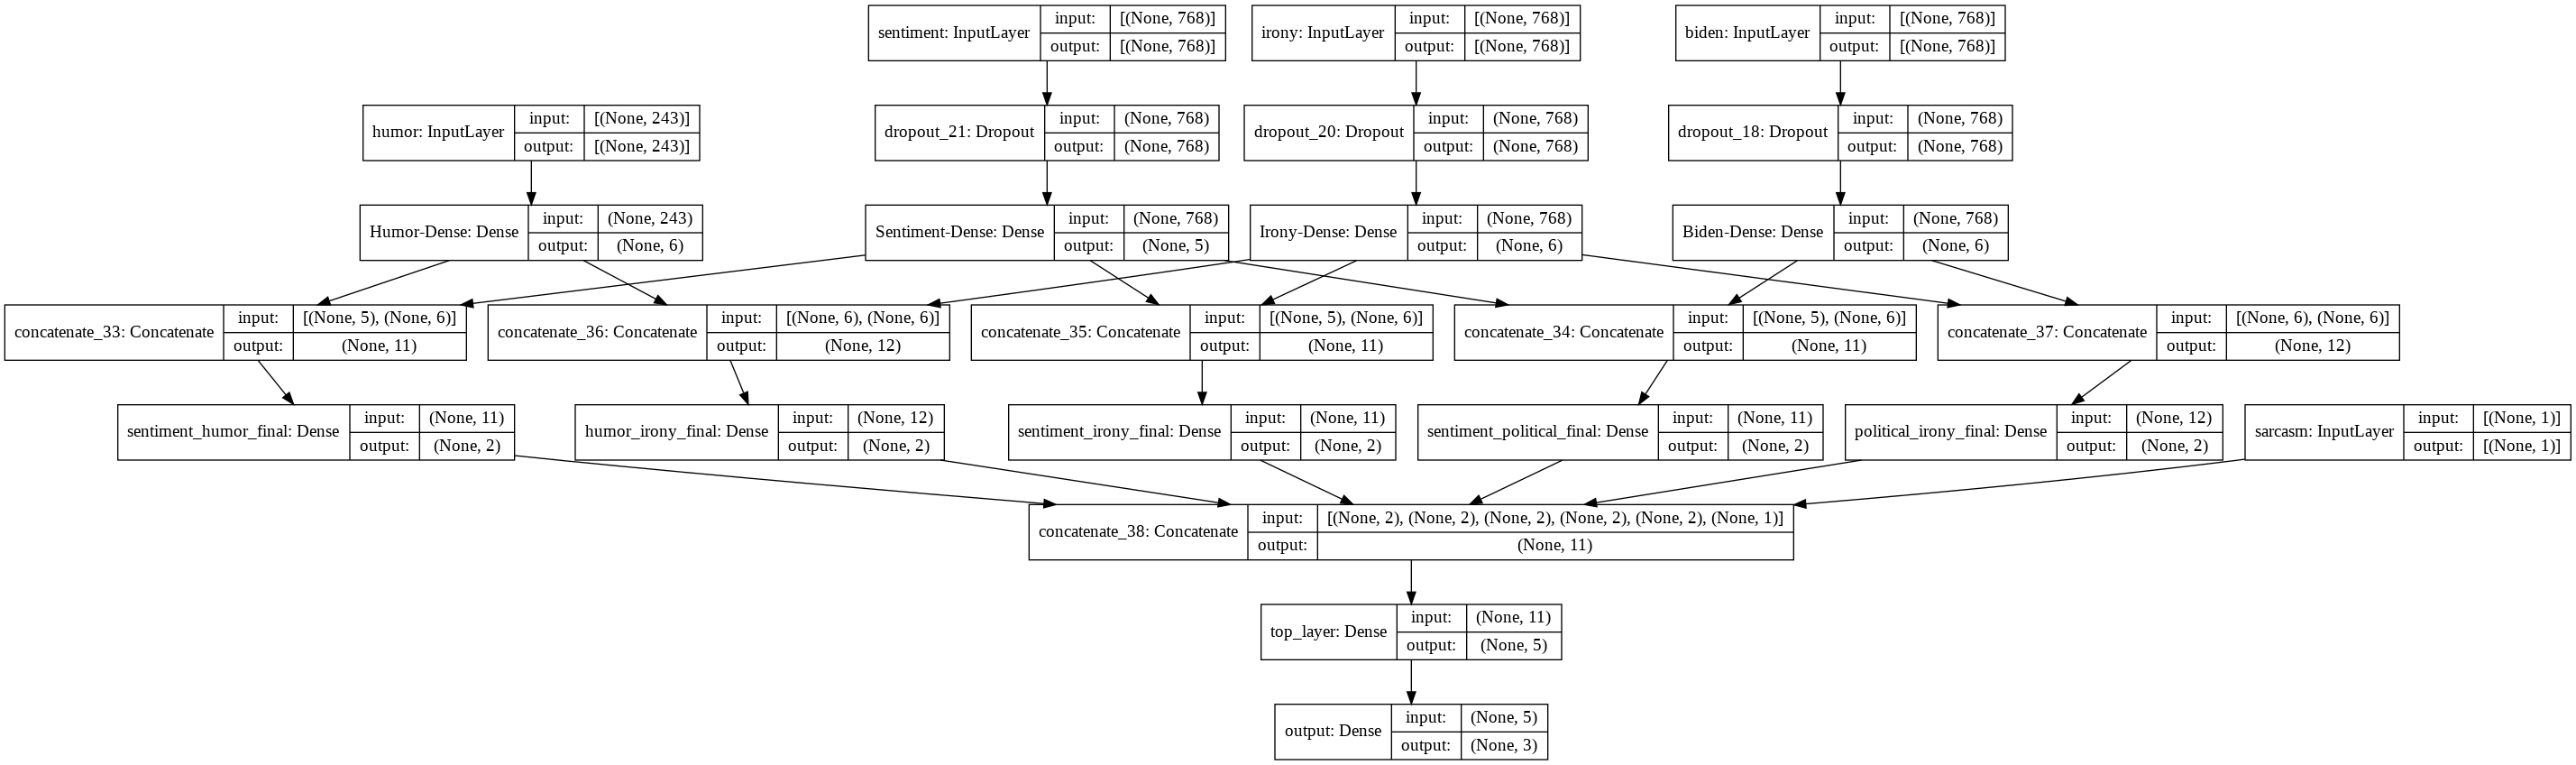

In [74]:
%cd /content/drive/MyDrive/meme_classification_data/MMN_Features
model.save('model4.h5')
keras.utils.plot_model(model, "model4.png", show_shapes=True)

#['Class0: 117', 'Class1: 167', 'Class2: 115']
#              precision    recall  f1-score   support
#
#           0       0.42      0.40      0.41       121
#           1       0.41      0.50      0.45       138
#           2       0.43      0.36      0.39       140
#
#    accuracy                           0.42       399
#   macro avg       0.42      0.42      0.42       399
#weighted avg       0.42      0.42      0.42       399
